In [864]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


In [865]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [866]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reviews.csv')

In [867]:
dataset

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo
...,...,...,...,...,...,...,...,...,...,...,...,...
12490,gp:AOqpTOEQPqib7pb6vFyjMY9JEfsMs_u8WCdqg6mbcar...,Mildred Olima,https://play-lh.googleusercontent.com/a-/AOh14...,"I really like the planner, it helps me achieve...",5,0,4.5.4,2018-12-21 00:13:09,NaN,NaN,newest,com.appxy.planner
12491,gp:AOqpTOE1KKOOVVKUfhAfXQs2NfJpoywfucrJCMK3Hmu...,Roaring Grizzly Bear,https://play-lh.googleusercontent.com/a-/AOh14...,😁****😁,5,0,NaN,2018-12-12 21:52:56,NaN,NaN,newest,com.appxy.planner
12492,gp:AOqpTOFEn5UgYYggqiHKauDJVLLN8-16nk1AfZbEhkj...,amirbadang,https://play-lh.googleusercontent.com/-CM2FcrU...,Very useful apps. You must try it,5,0,4.5.4,2018-12-11 15:49:43,NaN,NaN,newest,com.appxy.planner
12493,gp:AOqpTOHOH6YdYLR91qZdYpeIVkMI-LeAE0EwYgrctid...,Emma Stebbins,https://play-lh.googleusercontent.com/-oCj6g6k...,Would pay for this if there were even more add...,5,0,4.5.4,2018-12-06 04:59:26,NaN,NaN,newest,com.appxy.planner


In [868]:
dataset = dataset.loc[:,['content','score']]

In [869]:
dataset

,content,score
0,I cannot open the app anymore,1
1,I have been begging for a refund from this app...,1
2,Very costly for the premium version (approx In...,1
3,"Used to keep me organized, but all the 2020 UP...",1
4,Dan Birthday Oct 28,1
...,...,...
12490,"I really like the planner, it helps me achieve...",5
12491,😁****😁,5
12492,Very useful apps. You must try it,5
12493,Would pay for this if there were even more add...,5


In [870]:
values = dataset.score.value_counts()

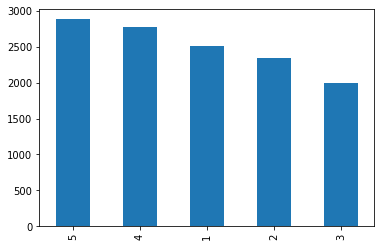

In [871]:
values.plot(kind='bar')

In [872]:
dataset.isnull().sum()

content    0
score      0
dtype: int64

In [873]:
def convert(x):
  if x<=2:
    return 0
  if x==3:
    return 1
  else:
    return 2

In [874]:
dataset.score = dataset.score.apply(convert)

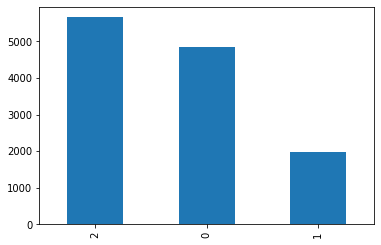

In [875]:
values = dataset.score.value_counts()
values.plot(kind='bar')

In [876]:
dataset


,content,score
0,I cannot open the app anymore,0
1,I have been begging for a refund from this app...,0
2,Very costly for the premium version (approx In...,0
3,"Used to keep me organized, but all the 2020 UP...",0
4,Dan Birthday Oct 28,0
...,...,...
12490,"I really like the planner, it helps me achieve...",2
12491,😁****😁,2
12492,Very useful apps. You must try it,2
12493,Would pay for this if there were even more add...,2


# Text Cleaning

In [877]:
def clean(x):
  x = x.str.lower()
  x.replace(r"https?//[a-z0-9./]",' ',inplace= True,regex=True)
  x.replace(r'[^a-z]',' ',inplace=True,regex=True)
  x.replace(r' +',' ',inplace=True,regex=True)

  return x


In [878]:
dataset.content = clean(dataset.content)

In [879]:
dataset

,content,score
0,i cannot open the app anymore,0
1,i have been begging for a refund from this app...,0
2,very costly for the premium version approx ind...,0
3,used to keep me organized but all the updates ...,0
4,dan birthday oct,0
...,...,...
12490,i really like the planner it helps me achieve ...,2
12491,,2
12492,very useful apps you must try it,2
12493,would pay for this if there were even more add...,2


In [880]:
dataset.isna().sum()

content    0
score      0
dtype: int64

In [881]:
dataset.content.replace(' ',np.nan,inplace=True)

In [882]:
dataset.dropna(subset=['content'], inplace=True)

In [883]:
dataset

,content,score
0,i cannot open the app anymore,0
1,i have been begging for a refund from this app...,0
2,very costly for the premium version approx ind...,0
3,used to keep me organized but all the updates ...,0
4,dan birthday oct,0
...,...,...
12489,its ok but we can not undestad repeated task s...,2
12490,i really like the planner it helps me achieve ...,2
12492,very useful apps you must try it,2
12493,would pay for this if there were even more add...,2


# Text preprocessing

In [884]:
stop_words = stopwords.words('english')

In [885]:
def preprocess(x):
  tokens = word_tokenize(x)
  without_stopwords = [w for w in tokens if w not in stop_words]

  # ps = PorterStemmer()
  # stemmed_words = [ps.stem(w) for w in without_stopwords]
  lemmatizer = WordNetLemmatizer()
  lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in without_stopwords]

  return lemma_words



In [886]:
dataset.content = dataset.content.apply(preprocess)

In [887]:
dataset

,content,score
0,"[open, app, anymore]",0
1,"[begging, refund, app, month, nobody, replying]",0
2,"[costly, premium, version, approx, indian, rup...",0
3,"[used, keep, organized, updates, made, mess, t...",0
4,"[dan, birthday, oct]",0
...,...,...
12489,"[ok, undestad, repeated, task, shedule]",2
12490,"[really, like, planner, helps, achieve, tasks,...",2
12492,"[useful, apps, must, try]",2
12493,"[would, pay, even, additions, updates, absolut...",2


In [888]:
dataset.content = dataset.content.apply(lambda y: np.nan if len(y)==0 else y)
dataset.dropna(subset=['content'], inplace=True)
dataset

,content,score
0,"[open, app, anymore]",0
1,"[begging, refund, app, month, nobody, replying]",0
2,"[costly, premium, version, approx, indian, rup...",0
3,"[used, keep, organized, updates, made, mess, t...",0
4,"[dan, birthday, oct]",0
...,...,...
12489,"[ok, undestad, repeated, task, shedule]",2
12490,"[really, like, planner, helps, achieve, tasks,...",2
12492,"[useful, apps, must, try]",2
12493,"[would, pay, even, additions, updates, absolut...",2


In [889]:
# text =['the',"boy's","cars","are","better","colors"]

In [890]:
# lemmatizer = WordNetLemmatizer()
# lemma_words = [lemmatizer.lemmatize("begs", pos='a')]

In [891]:
# lemma_words

# Feature engineering 

In [892]:
v = TfidfVectorizer( max_df=0.95,sublinear_tf=True)
X = v.fit_transform(dataset.content.astype(str))


In [893]:
Y = np.array(dataset.pop('score'))

In [894]:
Y

array([0, 0, 0, ..., 2, 2, 2])

In [895]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Logistic Regression Model

In [896]:
LR_model = LogisticRegression(solver='liblinear',max_iter=1000)


LR_model.fit(X_train, y_train)
print("Training accuracy: ",LR_model.score(X_train,y_train))
y_predict_lr = LR_model.predict(X_test)


print("Test accuraccy: ",accuracy_score(y_test, y_predict_lr))

Training accuracy:  0.7834427057041898
Test accuraccy:  0.7133629390391603


# Multinomial Naive Bayes Model

In [897]:
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)

print("Training accuracy: ",NB_model.score(X_train,y_train))
y_predict_nb = NB_model.predict(X_test)

print("Test accuraccy: ",accuracy_score(y_test, y_predict_nb))


Training accuracy:  0.7651691065118627
Test accuraccy:  0.7169963665724667
